Removing weight norm...


Conversion WAV → HiFi-GAN:   0%|          | 0/5 [00:00<?, ?it/s]

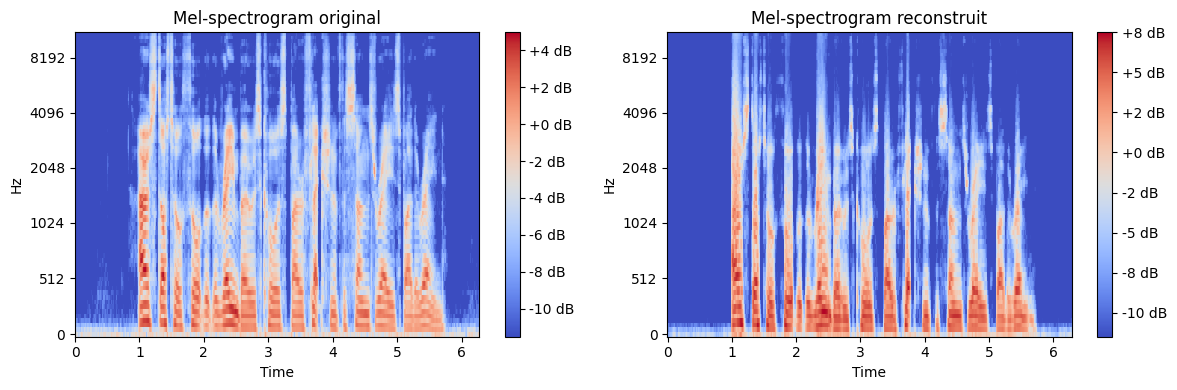

🎵 Audio original :


🎵 Audio reconstruit HiFi-GAN :


Conversion WAV → HiFi-GAN:  20%|██        | 1/5 [00:00<00:01,  2.65it/s]

<Figure size 640x480 with 0 Axes>

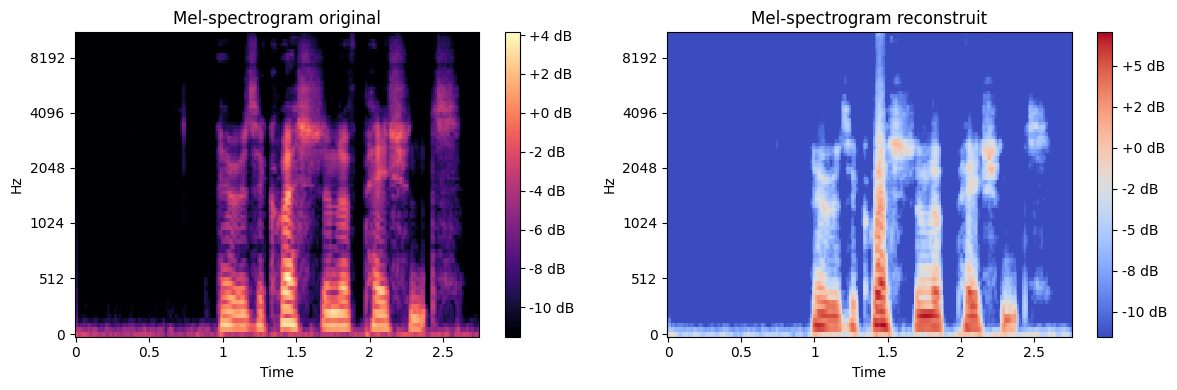

🎵 Audio original :


🎵 Audio reconstruit HiFi-GAN :


Conversion WAV → HiFi-GAN:  40%|████      | 2/5 [00:00<00:00,  3.20it/s]

<Figure size 640x480 with 0 Axes>

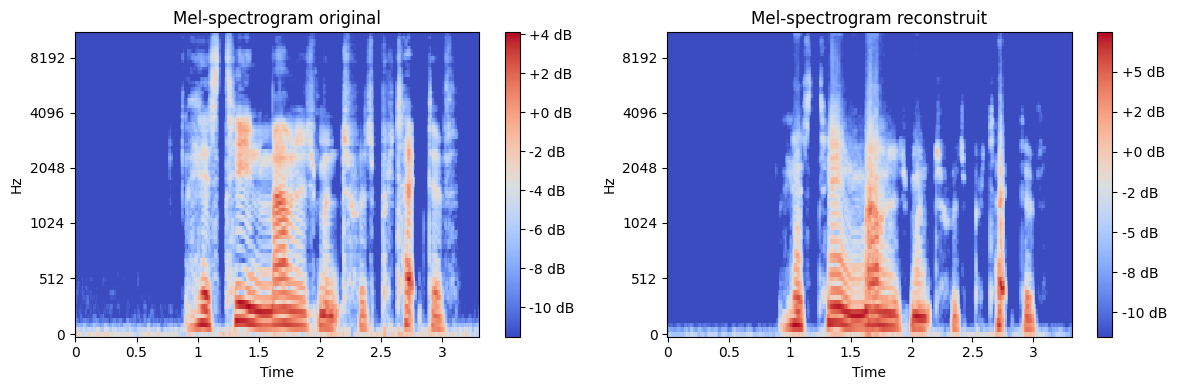

🎵 Audio original :


🎵 Audio reconstruit HiFi-GAN :


Conversion WAV → HiFi-GAN:  60%|██████    | 3/5 [00:00<00:00,  3.14it/s]

<Figure size 640x480 with 0 Axes>

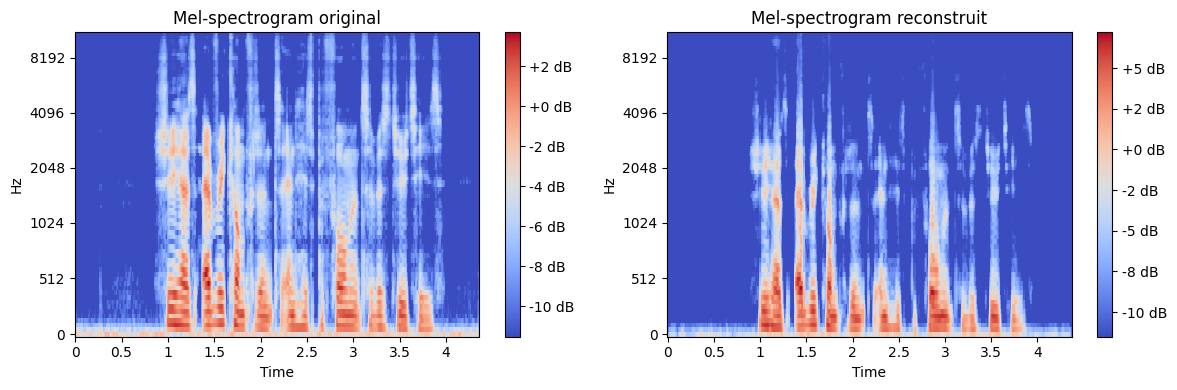

🎵 Audio original :


🎵 Audio reconstruit HiFi-GAN :


Conversion WAV → HiFi-GAN:  80%|████████  | 4/5 [00:01<00:00,  3.01it/s]

<Figure size 640x480 with 0 Axes>

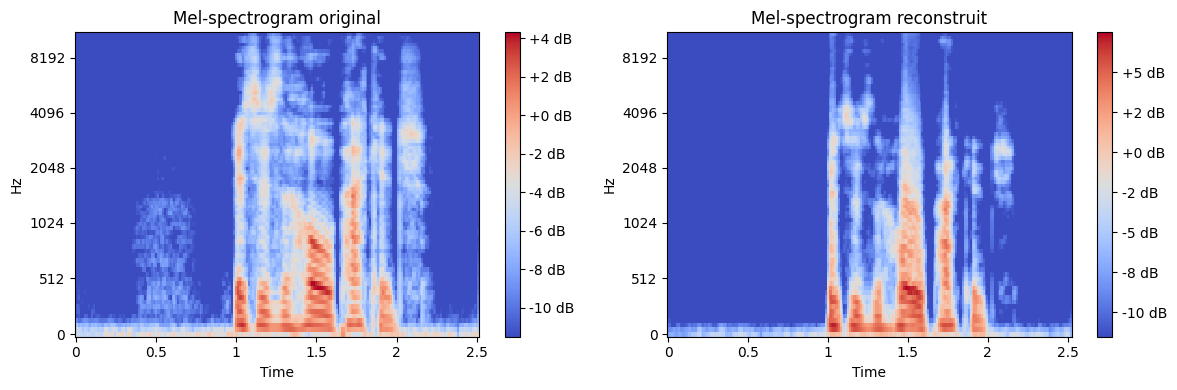

🎵 Audio original :


🎵 Audio reconstruit HiFi-GAN :


Conversion WAV → HiFi-GAN: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

✅ Tous les fichiers WAV reconstruits et visualisés dans /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/outputs_hifigan


<Figure size 640x480 with 0 Axes>

In [47]:
# ================================================================
# HiFi-GAN : Visualisation et comparaison Mel-Spectrogram
# Avec lecture audio originale et reconstruite
# ================================================================

import os
import sys
import json
import torch
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm
from IPython.display import Audio, display
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
# ------------------------------------------------
# 1️⃣ Chemins du modèle
# ------------------------------------------------
# Chemin vers le dossier contenant HiFi-GAN
hifi_path = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/hifi-gan"
sys.path.append(hifi_path)

MODEL_DIR = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/hifi-gan"
GEN_PATH = os.path.join(MODEL_DIR, "generator_v1")
CFG_PATH = os.path.join(MODEL_DIR, "config_v1.json")
assert os.path.exists(GEN_PATH), f"❌ {GEN_PATH} manquant"
assert os.path.exists(CFG_PATH), f"❌ {CFG_PATH} manquant"
"""
- GEN_PATH → fichier des poids du modèle pré-entraîné.
- CFG_PATH → fichier de configuration, contient tous les hyperparamètres : 
nombre de couches, filtres, kernels…
- assert → vérifie que les fichiers existent pour éviter des erreurs plus loin.
- Point clé : le modèle et la config doivent correspondre exactement à la version 
du générateur (v1, v2 ou v3).
"""
# ------------------------------------------------
# Clonage HiFi-GAN
# ------------------------------------------------
from models import Generator
from env import AttrDict
"""
- Generator → classe définissant le vocodeur neural.
- AttrDict → transforme un dictionnaire en objet avec attributs 
(h.resblock_kernel_sizes etc.), ce que le modèle attend.
- distinction entre architecture du modèle et poids pré-entraînés.
"""

device = "cuda" if torch.cuda.is_available() else "cpu"
"""
- Vérifie si un GPU est disponible, sinon utilise le CPU.
- Important pour accélérer le calcul, car HiFi-GAN est lourd.
"""
# ------------------------------------------------
# 3️⃣ Charger le modèle HiFi-GAN
# ------------------------------------------------

def load_hifigan_model(checkpoint=GEN_PATH, config=CFG_PATH, device=device):
    with open(config, "r") as f:
        cfg = json.load(f)
    h = AttrDict(cfg)
    model = Generator(h)
    state = torch.load(checkpoint, map_location=device)
    model.load_state_dict(state["generator"])
    model.eval()
    model.remove_weight_norm()
    model = model.to(device)
    return model
"""
- Lire le fichier de configuration JSON → dictionnaire Python → AttrDict.
- Créer le modèle HiFi-GAN (Generator(h)).
- Charger les poids pré-entraînés (state["generator"]).
- Mettre le modèle en mode évaluation (.eval()) → désactive dropout, batchnorm etc.
- Supprimer la normalisation des poids (remove_weight_norm) → nécessaire pour l’inférence.
- Envoyer le modèle sur le device choisi (GPU ou CPU).
**distinction entre architecture et poids, et importance du mode évaluation pour l’inférence.
"""
hifigan = load_hifigan_model()

# ------------------------------------------------
# 4️⃣ Fonction : WAV → Mel float
# ------------------------------------------------
def wav_to_mel(path, sr=22050, n_fft=1024, hop_length=256, n_mels=80):
    y, _ = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel = np.log(np.clip(mel, a_min=1e-5, a_max=None))  # log-mel
    mel_tensor = torch.tensor(mel).unsqueeze(0).to(device)  # [1, 80, T]
    return mel_tensor, mel, y
"""
- librosa.load → lit le fichier WAV et le normalise entre -1 et 1.
- melspectrogram → convertit le signal en représentation temps-fréquence (80 bandes mel).
- log → compressé pour correspondre à la perception humaine et à l’entrainement HiFi-GAN.
- np.clip(mel, a_min=1e-5, a_max=None)
    Objectif : éviter les valeurs trop petites ou nulles dans le spectrogramme.
- np.clip limite les valeurs de mel :
    Toute valeur < 1e-5 devient 1e-5.
    a_max=None signifie qu'on ne fixe pas de maximum.
    Pourquoi ? Parce que le logarithme d'une valeur proche de zéro ou négative est 
    mathématiquement invalide ou très grand en négatif.
- np.log(...): On applique le logarithme naturel à chaque valeur du spectrogramme.
    Cela transforme le spectrogramme en log-melspectrogramme, ce qui est plus proche de la 
    perception humaine du son (car notre oreille perçoit les intensités de manière 
    logarithmique).
- torch.tensor(mel).unsqueeze(0).to(device)
    - torch.tensor(mel) : conversion du tableau NumPy en tenseur PyTorch.
    -.unsqueeze(0) : ajoute une dimension en début (batch size = 1).
    Si mel est de forme [80, T], alors mel_tensor devient [1, 80, T].
    T = le nombre de frames temporelles: Chaque colonne du melspectrogramme 
    correspond à un instant dans le temps.
    Donc T est la durée du signal audio exprimée en tranches temporelles (ou "frames").
    Plus T est grand, plus le spectrogramme couvre une longue durée audio.
    Dimensions typiques du melspectrogramme : [1, 80, T] :
        1 : batch size (on traite un seul exemple à la fois)
        80 : nombre de bandes de fréquences (souvent 80 mels)
        T : nombre de tranches temporelles (variable selon la durée du signal)
    -.to(device) : envoie le tenseur sur le GPU ou CPU selon device.
    
** HiFi-GAN travaille sur mel float, pas sur des images ou spectrogrammes en PNG.
** Cette transformation est essentielle pour préparer un melspectrogramme en entrée 
d’un modèle comme HiFi-GAN, qui attend un tenseur de forme [batch_size, n_mel_channels, time].
"""
# ------------------------------------------------
# 5️⃣ Batch processing WAV avec visualisation
# ------------------------------------------------
INPUT_DIR = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/train"
OUTPUT_DIR = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/outputs_hifigan"
os.makedirs(OUTPUT_DIR, exist_ok=True)

wav_files = [f for f in os.listdir(INPUT_DIR) if f.endswith(".wav")]
part_of_wav_files = wav_files[:5]
for file in tqdm(part_of_wav_files, desc="Conversion WAV → HiFi-GAN"):
    wav_path = os.path.join(INPUT_DIR, file)
    
    # 🔹 Conversion en mel
    mel_tensor, mel_orig, y_orig = wav_to_mel(wav_path)
    
    # 🔹 Génération audio avec HiFi-GAN
    """
    - torch.no_grad() → pas de calcul de gradient pour économiser mémoire.
    - squeeze() → supprime la dimension batch [1, T] → [T].
    - Normalisation pour éviter clipping audio.
    - Sauvegarde le WAV reconstruit pour écoute et analyse.
    """
    with torch.no_grad():
        audio = hifigan(mel_tensor).cpu().squeeze().numpy()
    
    # 🔹 Normalisation audio
    audio = audio / np.max(np.abs(audio) + 1e-9)
    
    # 🔹 Sauvegarde reconstruction
    out_path = os.path.join(OUTPUT_DIR, file)
    sf.write(out_path, audio, 22050)
    
    # 🔹 Calcul du mel reconstruit
    mel_rec = librosa.feature.melspectrogram(y=audio, sr=22050, n_fft=1024, hop_length=256, n_mels=80)
    mel_rec = np.log(np.clip(mel_rec, 1e-5, None))
    
    # 🔹 Affichage des mel-spectrograms côte à côte
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    librosa.display.specshow(mel_orig, sr=22050, hop_length=256, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-spectrogram original")
    
    plt.subplot(1,2,2)
    librosa.display.specshow(mel_rec, sr=22050, hop_length=256, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-spectrogram reconstruit")
    
    plt.tight_layout()
    plt.show()
    plt.clf() # Clears the current figure
    
    # 🔹 Audio player : original et reconstruit
    print("🎵 Audio original :")
    display(Audio(y_orig, rate=22050))
    
    print("🎵 Audio reconstruit HiFi-GAN :")
    display(Audio(audio, rate=22050))

print(f"✅ Tous les fichiers WAV reconstruits et visualisés dans {OUTPUT_DIR}")


In [48]:
# prepare_wavs.py
import os, glob, soundfile as sf, librosa
from pydub import AudioSegment

SR = 22050

def fix_file(in_path, out_path):
    y, sr = librosa.load(in_path, sr=SR, mono=True)
    # trim silences
    yt, _ = librosa.effects.trim(y, top_db=30)
    # normalize RMS to -20 dBFS
    rms = (yt**2).mean()**0.5
    target_rms = 0.1
    if rms > 0:
        yt = yt * (target_rms / rms)
    sf.write(out_path, yt, SR, subtype='PCM_16')

def process_folder(src_folder, dst_folder):
    os.makedirs(dst_folder, exist_ok=True)
    for p in sorted(glob.glob(os.path.join(src_folder, '*.wav'))):
        fname = os.path.basename(p)
        fix_file(p, os.path.join(dst_folder, fname))

if __name__ == "__main__":
    process_folder('/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/train', '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/processed')
    process_folder('/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/train', '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/processed')

In [49]:
# fe.py
import os, glob, numpy as np
import librosa
import soundfile as sf

SR=22050
N_FFT=1024
HOP=256
WIN=1024
N_MELS=80
FMIN=0
FMAX=8000

def wav_to_mel(path):
    y, sr = librosa.load(path, sr=SR, mono=True)
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP,
        win_length=WIN, n_mels=N_MELS, fmin=FMIN, fmax=FMAX, power=1.0
    )
    # log + normalize
    mel = np.log(np.clip(S, 1e-9, None))
    return mel.astype(np.float32)

def process_folder(in_dir, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    for p in sorted(glob.glob(os.path.join(in_dir, '*.wav'))):
        m = wav_to_mel(p)
        fname = os.path.splitext(os.path.basename(p))[0] + '.npy'
        np.save(os.path.join(out_dir, fname), m)

if __name__ == "__main__":
    process_folder('/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/processed', '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/mels')
    process_folder('/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/processed', '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/mels')

In [ ]:
# ...existing code...
# align.py
import numpy as np, glob, os, re
import librosa
from scipy.spatial.distance import cdist
from dtw import dtw   # pip install dtw-python

def align_pair(melA, melB):
    # mel: (n_mels, T)
    D = cdist(melA.T, melB.T, metric='cosine')   # shape (T_a, T_b)
    # use librosa DTW on distance matrix
    D_acc, wp = librosa.sequence.dtw(C=D)
    # wp is list/array of (i,j) pairs (path), take columns
    pathA = wp[:, 0].astype(int)
    pathB = wp[:, 1].astype(int)
    aligned_A = melA[:, pathA]
    aligned_B = melB[:, pathB]
    return aligned_A, aligned_B

# output folders
OUT_A = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/aligned'
OUT_B = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/aligned'
os.makedirs(OUT_A, exist_ok=True)
os.makedirs(OUT_B, exist_ok=True)

a_dir = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/mels'
b_dir = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/mels'
a_files = sorted(glob.glob(os.path.join(a_dir, '*.npy')))
b_files = sorted(glob.glob(os.path.join(b_dir, '*.npy')))

print(f"OUT_A={OUT_A}, OUT_B={OUT_B}")
print(f"Found {len(a_files)} files in speaker_A/mels")
print(f"Found {len(b_files)} files in speaker_B/mels")

if not a_files:
    print("No .npy files matched the A glob. Check that mels were generated and path is correct.")
if not b_files:
    print("No .npy files matched the B glob. Check that mels were generated and path is correct.")

# build suffix map for B files: key = part after first underscore, value = list of files
b_suffix_map = {}
for p in b_files:
    name = os.path.basename(p)
    if '_' in name:
        suffix = name.split('_', 1)[1]
    else:
        suffix = name
    b_suffix_map.setdefault(suffix, []).append(p)

saved = 0
skipped = 0

for a_file in a_files:
    base = os.path.basename(a_file)
    # 1) exact match
    b_file = os.path.join(b_dir, base)
    matched = None

    if os.path.exists(b_file):
        matched = b_file
        print(f"Processing {base} -> exact partner found: {os.path.basename(matched)}")
    else:
        # 2) try suffix match (handles p225_001_mic1.npy <-> p226_001_mic1.npy)
        suffix = base.split('_', 1)[1] if '_' in base else base
        if suffix in b_suffix_map:
            matched = b_suffix_map[suffix][0]
            print(f"Processing {base} -> matched partner by suffix: {os.path.basename(matched)}")
        else:
            # 3) fallback: search any b file that endswith the same suffix
            candidates = [p for p in b_files if p.endswith(suffix)]
            if candidates:
                matched = candidates[0]
                print(f"Processing {base} -> matched partner by endswithfinal.ipynb: {os.path.basename(matched)}")
            else:
                print(f"Processing {base} -> partner file missing, skipping")
                skipped += 1
                continue

    try:
        melA = np.load(a_file)
        melB = np.load(matched)
        a_al, b_al = align_pair(melA, melB)
        out_a_path = os.path.join(OUT_A, base)
        out_b_path = os.path.join(OUT_B, os.path.basename(matched))
        np.save(out_a_path, a_al)
        np.save(out_b_path, b_al)
        print(f"Saved: {out_a_path} , {out_b_path}")
        saved += 1
    except Exception as e:
        print(f"Error processing {base}: {e}")
        skipped += 1

print(f"Done. saved={saved}, skipped={skipped}")
# ...existing code...

OUT_A=/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/aligned, OUT_B=/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/aligned
Found 215 files in speaker_A/mels
Found 215 files in speaker_B/mels
Processing p225_001_mic1.npy -> matched partner by suffix: p226_001_mic1.npy
Saved: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/aligned/p225_001_mic1.npy , /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/aligned/p226_001_mic1.npy
Processing p225_002_mic1.npy -> matched partner by suffix: p226_002_mic1.npy
Saved: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/aligned/p225_002_mic1.npy , /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/aligned/p226_002_mic1.npy
Processing p225_003_mic1.npy -> matched partner by suffix: p226_003_mic1.npy
Saved: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/aligned/p225_003_mic1.npy , /home/adambtw/Proj

In [55]:
import torch
import torch.nn as nn

class ResConvBlock(nn.Module):
    def __init__(self, ch, ks=5, dilation=1):
        super().__init__()
        pad = (ks - 1) // 2 * dilation

        self.conv = nn.Sequential(
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch, ch, kernel_size=ks, padding=pad, dilation=dilation),
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch, ch, kernel_size=1)
        )

    def forward(self, x):
        return x + self.conv(x)



class MelMapper(nn.Module):
    def __init__(self, n_mels=80, hidden=512):
        super().__init__()

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv1d(n_mels, hidden, kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
        )

        # 6 residual blocks with increasing dilation
        dilations = [1, 2, 4, 1, 2, 4]
        self.resblocks = nn.Sequential(*[
            ResConvBlock(hidden, ks=5, dilation=d) for d in dilations
        ])

        # Decoder
        self.dec = nn.Sequential(
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden, n_mels, kernel_size=1)
        )

    def forward(self, m):
        h = self.enc(m)
        h = self.resblocks(h)
        out = self.dec(h)
        return out


In [56]:
# ...existing code...
import torch, glob, numpy as np
from torch.utils.data import Dataset, DataLoader
import os

class MelDataset(Dataset):
    def __init__(self, folderA, folderB, crop=128):
        # gather files
        a_files = sorted(glob.glob(os.path.join(folderA, '*.npy')))
        b_files = sorted(glob.glob(os.path.join(folderB, '*.npy')))

        # build suffix map for B
        b_map = {}
        for p in b_files:
            name = os.path.basename(p)
            suffix = name.split('_', 1)[1] if '_' in name else name
            b_map.setdefault(suffix, []).append(p)

        # build paired list (only keep A files that have a matching B)
        pairs = []
        missed = []
        for a in a_files:
            a_name = os.path.basename(a)
            # exact match preferred
            b_candidate = os.path.join(folderB, a_name)
            matched = None
            if os.path.exists(b_candidate):
                matched = b_candidate
            else:
                suffix = a_name.split('_', 1)[1] if '_' in a_name else a_name
                if suffix in b_map:
                    matched = b_map[suffix][0]
                else:
                    # fallback to endswith search
                    cand = [p for p in b_files if p.endswith(suffix)]
                    if cand:
                        matched = cand[0]

            if matched:
                pairs.append((a, matched))
            else:
                missed.append(a_name)

        if missed:
            print(f"MelDataset: {len(missed)} A files have no partner in B and will be skipped. Examples: {missed[:5]}")

        self.pairs = pairs
        self.crop = crop

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        a_path, b_path = self.pairs[idx]
        a = np.load(a_path)  # (n_mels, T)
        b = np.load(b_path)

        Ta = a.shape[1]; Tb = b.shape[1]
        T_min = min(Ta, Tb)

        # if both longer than crop -> random crop on shared interval
        if T_min > self.crop:
            s = np.random.randint(0, T_min - self.crop + 1)
            a = a[:, s:s+self.crop]
            b = b[:, s:s+self.crop]
        else:
            # pad to crop length (zero padding)
            def pad_to_crop(m, crop):
                if m.shape[1] >= crop:
                    return m[:, :crop]
                pad_len = crop - m.shape[1]
                return np.pad(m, ((0,0),(0,pad_len)), mode='constant', constant_values=0.0)
            a = pad_to_crop(a, self.crop)
            b = pad_to_crop(b, self.crop)

        return torch.from_numpy(a).float(), torch.from_numpy(b).float()

# ...existing code...

In [64]:
device='cuda'
model = MelMapper().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
ds = MelDataset('/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/aligned', '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/aligned', crop=256)
loader = DataLoader(ds, batch_size=8, shuffle=True, num_workers=4)

for epoch in range(1,501):
    model.train()
    for a,b in loader:
        a = a.to(device); b = b.to(device)
        pred = model(a)
        loss = torch.nn.functional.l1_loss(pred, b)
        opt.zero_grad(); loss.backward(); opt.step()
    print(f'epoch {epoch} ------> loss {loss.item()}')
    if epoch%10==0:
        torch.save(model.state_dict(), f'/home/adambtw/Projects/salmaspect/voice-conversion-gan/mappers_epochs/mapper_epoch{epoch}.pt')
        print(f"Saved mapper_epoch{epoch}.pt")

epoch 1 ------> loss 4.441875457763672
epoch 2 ------> loss 3.711597442626953
epoch 3 ------> loss 3.2909607887268066
epoch 4 ------> loss 2.0608530044555664
epoch 5 ------> loss 2.34613037109375
epoch 6 ------> loss 1.8364235162734985
epoch 7 ------> loss 1.3594697713851929
epoch 8 ------> loss 1.2043427228927612
epoch 9 ------> loss 1.4325076341629028
epoch 10 ------> loss 1.3325800895690918
Saved mapper_epoch10.pt
epoch 11 ------> loss 1.1898598670959473
epoch 12 ------> loss 1.1565929651260376
epoch 13 ------> loss 1.141848087310791
epoch 14 ------> loss 1.1247261762619019
epoch 15 ------> loss 1.208294153213501
epoch 16 ------> loss 1.0463058948516846
epoch 17 ------> loss 1.224785566329956
epoch 18 ------> loss 1.0353204011917114
epoch 19 ------> loss 1.2035150527954102
epoch 20 ------> loss 1.1812219619750977
Saved mapper_epoch20.pt
epoch 21 ------> loss 0.962505042552948
epoch 22 ------> loss 1.2297945022583008
epoch 23 ------> loss 1.0354154109954834
epoch 24 ------> loss 1.07

Removing weight norm...


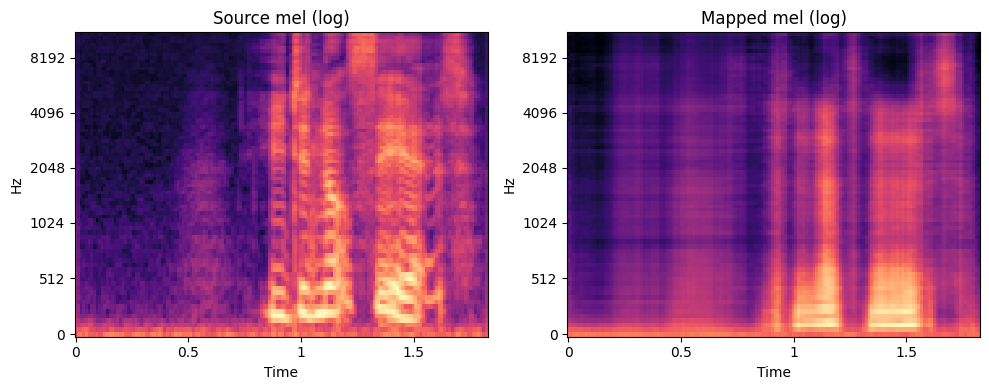

Original:


Converted:


In [68]:
# ...existing code...
# inference_vc.py  (fixed / completed cell)

import torch, numpy as np, librosa, soundfile as sf
from IPython.display import Audio, display
import matplotlib.pyplot as plt

SR = 22050
HOP = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

# load mapper and vocoder
mapper = MelMapper().to(device)
mapper.load_state_dict(torch.load('/home/adambtw/Projects/salmaspect/voice-conversion-gan/mappers_epochs/mapper_epoch50.pt', map_location=device))
mapper.eval()
vocoder = load_hifigan_model()

def mel_to_wav(mel, vocoder=vocoder, sr=SR):
    """
    mel: numpy (n_mels, T) or torch tensor [1, n_mels, T] or [n_mels, T]
    returns: numpy waveform (float32) normalized to [-1,1]
    """
    if isinstance(mel, np.ndarray):
        if mel.ndim == 2:
            mel_t = torch.from_numpy(mel).unsqueeze(0).float().to(device)
        elif mel.ndim == 3:
            mel_t = torch.from_numpy(mel).float().to(device)
        else:
            raise ValueError("Unexpected mel shape")
    elif isinstance(mel, torch.Tensor):
        mel_t = mel.float().to(device)
        if mel_t.dim() == 2:
            mel_t = mel_t.unsqueeze(0)
    else:
        raise TypeError("mel must be numpy or torch tensor")

    with torch.no_grad():
        audio = vocoder(mel_t).cpu().squeeze().numpy()
    audio = audio / (np.max(np.abs(audio)) + 1e-9)
    return audio.astype(np.float32)

def load_mel_and_wave(path):
    """
    Robust wrapper for wav_to_mel() which may have multiple signatures across cells.
    Returns: (mel_tensor [1,n_mels,T] on device, mel_numpy (n_mels,T), waveform numpy)
    """
    out = wav_to_mel(path)
    # handle tuple/list returns
    if isinstance(out, (tuple, list)):
        if len(out) == 3:
            mel_tensor, mel_orig, y_orig = out
            # mel_tensor might already be torch tensor or numpy
            if isinstance(mel_tensor, np.ndarray):
                mel_t = torch.from_numpy(mel_tensor).unsqueeze(0).float().to(device) if mel_tensor.ndim == 2 else torch.from_numpy(mel_tensor).float().to(device)
            elif isinstance(mel_tensor, torch.Tensor):
                mel_t = mel_tensor.float().to(device)
                if mel_t.dim() == 2:
                    mel_t = mel_t.unsqueeze(0)
            else:
                raise TypeError("unexpected mel_tensor type from wav_to_mel()")
            return mel_t, mel_orig, y_orig
        elif len(out) == 1:
            mel = out[0]
            mel_t = torch.from_numpy(mel).unsqueeze(0).float().to(device)
            y_orig, _ = librosa.load(path, sr=SR)
            return mel_t, mel, y_orig
        else:
            # unexpected tuple length -> try to interpret first element as mel
            mel = out[0]
            mel_t = torch.from_numpy(mel).unsqueeze(0).float().to(device)
            y_orig, _ = librosa.load(path, sr=SR)
            return mel_t, mel, y_orig
    else:
        # single return (likely numpy mel)
        mel = out
        mel_t = torch.from_numpy(mel).unsqueeze(0).float().to(device)
        y_orig, _ = librosa.load(path, sr=SR)
        return mel_t, mel, y_orig

# -------------------------
# Inference on a source wav
# -------------------------
src_wav = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/test/p225_365_mic1.wav'
mel_tensor, mel_orig, y_orig = load_mel_and_wave(src_wav)  # now robust to different wav_to_mel signatures

# map mel -> target mel with mapper
with torch.no_grad():
    pred_mel = mapper(mel_tensor)  # [1, n_mels, T]

# vocode predicted mel to waveform
wav_out = mel_to_wav(pred_mel)  # numpy waveform

# save result
sf.write('converted.wav', wav_out, SR)

# optional: visualize / listen
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
librosa.display.specshow(mel_orig, sr=SR, hop_length=HOP, x_axis='time', y_axis='mel')
plt.title("Source mel (log)")
plt.subplot(1,2,2)
pred_mel_np = pred_mel.cpu().numpy()[0]
librosa.display.specshow(pred_mel_np, sr=SR, hop_length=HOP, x_axis='time', y_axis='mel')
plt.title("Mapped mel (log)")
plt.tight_layout()
plt.show()

print("Original:")
display(Audio(y_orig, rate=SR))
print("Converted:")
display(Audio(wav_out, rate=SR))
# ...existing code...